In [ ]:
# default_exp image_segmentation

# Image Segmentation

# Task 6: Image segmentation with MaxFlow cut

Implementujte variantu úlohy interaktivní segmentace obrazu vhodnou pro barvení ručních kreseb. Hranici mezi jednotlivými oblastmi stanovte pomocí maximalizace toku v síti. Pro vlastní výpočet využijte některou z dostupných knihoven (např. GridCut). Demonstrujte funkčnost řešení na příkladě obarvení jednoduché ruční kresby dvěma různými barvami.

In [ ]:
# export
import numpy as np
import maxflow
from numpy.linalg import norm

In [ ]:
import matplotlib.pyplot as plt
from dzotools.utils import imgload
from dzotools.fourier import draw_pair

In [ ]:
back = imgload('data/segmentation/warhol_frog_bg_bold.png', convert="L")
color_raw = imgload('data/segmentation/warhol_frog_fg.png')

In [ ]:
WHITE = np.array((255, 255, 255))
BLUE = np.array((135, 204, 255))
GREEN = np.array((153, 204, 153))

Since the colored image does not contain exact colors let's quantize them to be an exact match.

In [ ]:
# exports
def quantize_image(arr):
    """Make the colors perfect and exact RGB values."""
    stacked = np.stack([
        norm(arr - WHITE, axis=-1), 
        norm(arr - BLUE, axis=-1), 
        norm(arr - GREEN, axis=-1)], 
        axis=-1
    )
    
    # Broadcast into higher dimension to make numpy where happy
    indexes = np.argmin(stacked, axis=-1)[..., None]
    
    return np.where(indexes == 0, WHITE, (np.where(indexes == 1, BLUE, GREEN)))

In [ ]:
color = quantize_image(color_raw)

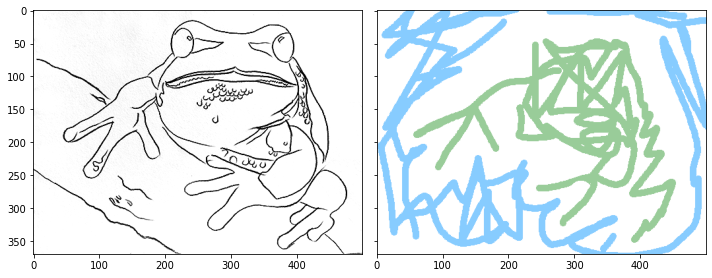

In [ ]:
draw_pair(back, color)
plt.show()

Boundary value is $0$, white value is $255$. Only blue and green are used for coloring purposes.

In [ ]:
# exports
rescale = lambda v: 255 * np.exp(-v*v / 32)

In [ ]:
# exports
def get_maxflow_graph(back: np.ndarray, color: np.ndarray) -> (np.ndarray, maxflow.GraphInt):
    """Calculate the segmentation using maxflow graph optimization.
    
    Assumes that the color array only contains 2 colors 
    where one of them is blue and the other one green.
    """
    TERMINAL_MULTIPLIER = 40
    
    graph = maxflow.Graph[int](0, 0)
    nodeids = graph.add_grid_nodes(back.shape)
    
    graph.add_grid_tedges(
        nodeids, 
        np.all(color == BLUE, axis=-1) * TERMINAL_MULTIPLIER,
        np.all(color == GREEN, axis=-1) * TERMINAL_MULTIPLIER,
    )
    
    minx = rescale(255 - np.minimum(back[:, 1:], back[:, :-1]))
    miny = rescale(255 - np.minimum(back[1:, :], back[:-1, :]))
    
    edgex = np.array(
        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]]
    )
    edgey = np.array(
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]
    )

    graph.add_grid_edges(nodeids[:, :-1], minx, edgex, symmetric=True)
    graph.add_grid_edges(nodeids[:-1, :], miny, edgey, symmetric=True)
    
    return nodeids, graph

In [ ]:
nodeids, graph = get_maxflow_graph(back, color)
# Calculate the maximum flow
graph.maxflow()
# Get the segments of the nodes in the grid
sgm = graph.get_grid_segments(nodeids)
# Color the image with preset colors
colored = np.where(sgm[..., None], GREEN, BLUE)

Combine the prediction and show the final image.

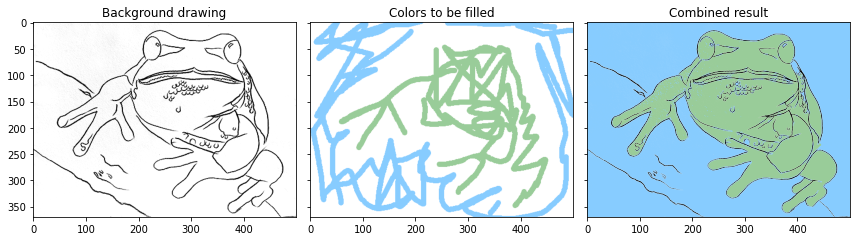

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 8))
ax[0].imshow(back, vmin=0, vmax=255, cmap="gray")
ax[0].set_title("Background drawing")
ax[1].imshow(color, vmin=0, vmax=255)
ax[1].set_title("Colors to be filled")
ax[2].imshow(colored, vmin=0, vmax=255)
ax[2].imshow(back, vmin=0, vmax=255, cmap="gray", alpha=1 - back/255)
ax[2].set_title("Combined result")
plt.tight_layout()
plt.show()